In [0]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [0]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import pandas as pd
import random

Using TensorFlow backend.


In [0]:
np.random.seed(0)

In [0]:
# Implement load the data here.
with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f)
#Load test data
with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)
 
    
# Split out features and labels
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

In [0]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [0]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels"
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels"
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels"
assert(X_train.shape[1:] == (32,32,3)), "The dimensions of the images are not (32,32,3)"
assert(X_val.shape[1:] == (32,32,3)), "The dimensions of the images are not (32,32,3)"
assert(X_test.shape[1:] == (32,32,3)), "The dimensions of the images are not (32,32,3)"

In [0]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
print(data)

    ClassId                                           SignName
0         0                               Speed limit (20km/h)
1         1                               Speed limit (30km/h)
2         2                               Speed limit (50km/h)
3         3                               Speed limit (60km/h)
4         4                               Speed limit (70km/h)
5         5                               Speed limit (80km/h)
6         6                        End of speed limit (80km/h)
7         7                              Speed limit (100km/h)
8         8                              Speed limit (120km/h)
9         9                                         No passing
10       10       No passing for vechiles over 3.5 metric tons
11       11              Right-of-way at the next intersection
12       12                                      Priority road
13       13                                              Yield
14       14                                            

In [0]:
num_of_samples = []

cols = 5
num_classes = 43


In [0]:
def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img


In [0]:
# histogram equalization
def equalize(img):
  img = cv2.equalizeHist(img)
  return img

In [0]:
def preprocessing(img):
  img = grayscale(img)
  img = equalize(img)
  img = img/255
  return img

X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

In [0]:
X_train = X_train.reshape(34799, 32, 32,1)
X_test = X_test.reshape(12630, 32, 32,1)
X_val = X_val.reshape(4410, 32, 32,1)

In [0]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 1)
(12630, 32, 32, 1)
(4410, 32, 32, 1)


In [0]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [0]:
def modified_model():
  model = Sequential()
  model.add(Conv2D(60,(5,5), input_shape=(32,32,1),activation='relu'))
  model.add(Conv2D(60,(5,5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Conv2D(30,(3,3),activation='relu'))
  model.add(Conv2D(30,(3,3),activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  #model.add(Dropout(0.5))
  model.add(Flatten())
  model.add(Dense(500,activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes, activation = 'softmax'))
  #Compile model
  model.compile(Adam(lr=0.001),loss='categorical_crossentropy',metrics =['accuracy'])
  return model

In [0]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(width_shift_range =0.1,
                  height_shift_range =0.1,
                  zoom_range=0.2,
                  shear_range =0.1,
                  rotation_range =10)

In [0]:
datagen.fit(X_train)

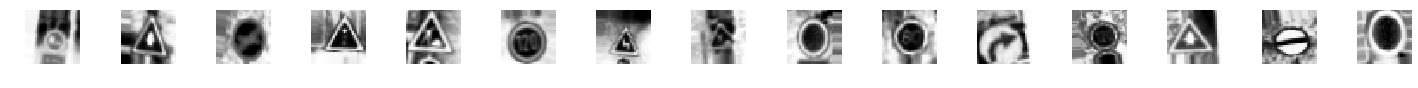

In [0]:
batches = datagen.flow(X_train, y_train, batch_size=20)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1,15,figsize=(20,5))
fig.tight_layout()

for i in range(15):
  axs[i].imshow(X_batch[i].reshape(32,32))
  axs[i].axis('off')

In [0]:
from sklearn.utils import resample

In [0]:
X_train_sample_list = []
y_train_sample_list = []

In [0]:
for i in range(3):
  X_train_sample , y_train_sample =  resample(X_train,  y_train,  n_samples = 34799)
  X_train_sample_list.append(X_train_sample)
  y_train_sample_list.append(y_train_sample)

In [0]:
model_list = []
history_list = []

In [0]:
for i in range(3):
  model = modified_model()
  datagen.fit(X_train_sample_list[i])
  history = model.fit_generator(datagen.flow(X_train_sample_list[i],y_train_sample_list[i],batch_size=50),steps_per_epoch=2000, epochs=10, validation_data =(X_val,y_val),shuffle=1)
  model_list.append(model)
  history_list.append(history)

Epoch 1/10
2000/2000 [==============================] - 65s 33ms/step - loss: 0.9473 - acc: 0.7222 - val_loss: 0.0940 - val_acc: 0.9719
Epoch 2/10
2000/2000 [==============================] - 61s 31ms/step - loss: 0.2313 - acc: 0.9286 - val_loss: 0.0460 - val_acc: 0.9882
Epoch 3/10
2000/2000 [==============================] - 63s 31ms/step - loss: 0.1495 - acc: 0.9534 - val_loss: 0.0322 - val_acc: 0.9918
Epoch 4/10
2000/2000 [==============================] - 61s 31ms/step - loss: 0.1158 - acc: 0.9645 - val_loss: 0.0398 - val_acc: 0.9900
Epoch 5/10
2000/2000 [==============================] - 62s 31ms/step - loss: 0.0936 - acc: 0.9708 - val_loss: 0.0536 - val_acc: 0.9855
Epoch 6/10
2000/2000 [==============================] - 64s 32ms/step - loss: 0.0857 - acc: 0.9735 - val_loss: 0.0257 - val_acc: 0.9921
Epoch 7/10
2000/2000 [==============================] - 63s 32ms/step - loss: 0.0741 - acc: 0.9772 - val_loss: 0.0492 - val_acc: 0.9868
Epoch 8/10
2000/2000 [==========================

Testing accuracy for 3 bagging-ensemble models: 0.9795724465558194
Testing accuracy for 3 bagging-ensemble models: 0.9795724465558194
Training accuracy for 3 bagging-ensemble models: 0.9992815885513952
Validation accuracy for 3 bagging-ensemble models: 0.9941043083900227


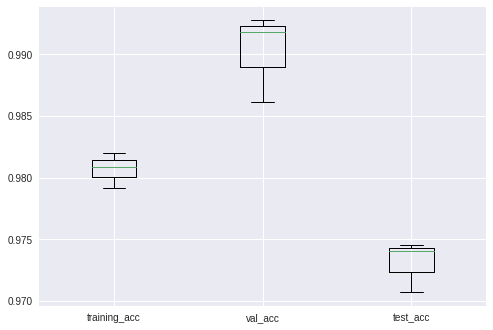

In [0]:
list = []
for i in range(3):
  list.append(np.argmax(model_list[i].predict(X_test),axis=1).tolist())
from scipy import stats
predict_class = stats.mode(np.asarray(list))[0]
test_accuracy_3 =sum(predict_class[0] ==np.argmax(y_test,axis=1).reshape((1,12630))[0])/len(y_test)
print('Testing accuracy for 3 bagging-ensemble models:',test_accuracy_3)
accuracy_list=[[],[],[]]
for i in range(3):
  accuracy_list[0].append(history_list[i].history['acc'][-1])
  accuracy_list[1].append(history_list[i].history['val_acc'][-1])
  accuracy_list[2].append(model_list[i].evaluate(X_test,y_test,verbose=0)[1])

import matplotlib.pyplot as plt
plt.boxplot(accuracy_list)
plt.xticks([1,2,3],['training_acc','val_acc','test_acc'])


print('Testing accuracy for 3 bagging-ensemble models:', test_accuracy_3)

training_predict_list = []
val_predict_list = []
for i in range(3):
  training_predict_list.append(np.argmax(model_list[i].predict(X_train),axis = 1).tolist())
  val_predict_list.append(np.argmax(model_list[i].predict(X_val),axis = 1).tolist())

predict_class_train = stats.mode(np.asarray(training_predict_list))[0]
predict_class_val = stats.mode(np.asarray(val_predict_list))[0]

train_accuracy_3 = sum(predict_class_train[0] == np.argmax(y_train, axis =1).reshape((1,34799))[0])/len(y_train)
print('Training accuracy for 3 bagging-ensemble models:', train_accuracy_3)

val_accuracy_3= sum(predict_class_val[0] == np.argmax(y_val, axis =1).reshape((1,4410))[0])/len(y_val)

print('Validation accuracy for 3 bagging-ensemble models:', val_accuracy_3)

